In [1]:
import sys
import nest_asyncio
import numpy as np

sys.path.insert(0,'..')

from ipywidgets import Video
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from src.server.db_api import connect

%matplotlib inline

## Establish a connection to EVA

In [2]:
nest_asyncio.apply()
connection = connect(host = '0.0.0.0', port = 5432) 
cursor = connection.cursor()

## Config variables

In [3]:
input_video_path = "../data/ua_detrac/ua_detrac.mp4"
output_video_path = "output.mp4"

## Visualize the input video and load into EVA

In [4]:
Video.from_file(input_video_path, embed=True)

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x19K[mdat\x00\x00\…

In [5]:
cursor.execute('UPLOAD INFILE "../data/ua_detrac/ua_detrac.mp4" PATH "video.mp4";')
response = cursor.fetch_all()
print(response)

Response Object:
@status: 0
@batch: Batch Object:
@dataframe: Empty DataFrame
Columns: []
Index: []
@batch_size: 0
@identifier_column: id
@metrics: None


In [6]:
cursor.execute('LOAD DATA INFILE "video.mp4" INTO MyVideo;')
response = cursor.fetch_all()
print(response)

Response Object:
@status: 0
@batch: Batch Object:
@dataframe:        Video  Num Loaded Frames
0  video.mp4                252
@batch_size: 1
@identifier_column: id
@metrics: None


In [7]:
cursor.execute("""CREATE UDF IF NOT EXISTS MidasDepthEstimator
      INPUT  (frame NDARRAY UINT8(3, ANYDIM, ANYDIM))
      OUTPUT (frame NDARRAY UINT8(3, ANYDIM, ANYDIM))
      TYPE  Classification
      IMPL  'src/udfs/midas_depth_estimator.py';
      """)
response = cursor.fetch_all()
print(response)

Response Object:
@status: 0
@batch: Batch Object:
@dataframe: Empty DataFrame
Columns: []
Index: []
@batch_size: 0
@identifier_column: id
@metrics: None


## Running our target UDF on the input video

In [8]:
cursor.execute("""SELECT id, MidasDepthEstimator(data) FROM MyVideo""")
response = cursor.fetch_all()

### TODO: For some reason, the frame batches are jumbled !?

In [9]:
sorted_response = response.batch.frames.sort_values(['id'])

## Visualize the results

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x01h\xd9mdat\x00\x…

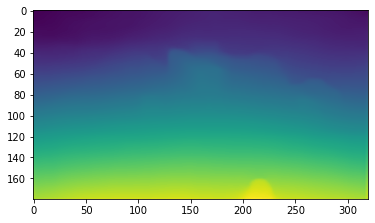

In [10]:
fig, ax = plt.subplots()
images_list = []
for index, row in sorted_response.iterrows():
    im = ax.imshow(row['frames'], animated=True)
    images_list.append([im])
    
# create and save the animation
output_animation = animation.ArtistAnimation(fig, images_list, interval=50, blit=True, repeat_delay=1000)
output_animation.save('output.mp4')
Video.from_file('output.mp4')